In [27]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import copy
import random
import os, errno
import sys
from tqdm import trange

import torch
import torch.nn as nn
from torch import optim
from sklearn.manifold import TSNE
import torch.nn.functional as F

import matplotlib.pyplot as plt


from src.lstm_encoder_decoder import *

In [28]:
torch.__version__

'2.0.0+cu117'

# Data

Each trajectory is represented by a N x M matrix,

where N is the number of stay points, and M i number of all POIs


In [29]:
data = np.load('poi_small.npy', allow_pickle=True)
len(data), data[0].shape

(658, (124, 4))

In [30]:
M = 4

## Training

In [57]:
n_epochs = 10
batch_size = 1
learning_rate = 0.01

model = EncoderDecoder(input_size=M, hidden_size=256).cuda()

optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()


In [58]:
input_batches = [
    torch.from_numpy(x).type(torch.Tensor).view(x.shape[0], batch_size, x.shape[1]).cuda()
    for x in data
]

In [59]:
losses = []
losses_per_epoch = []
best_model = None

In [60]:
best_loss = 1e18
for epoch in range(n_epochs):
    epoch_losses = []
    for input_batch in tqdm(input_batches):
        # print("input_batch: ", input_batch.shape)
        
        # initialize hidden state
        encoder_hidden = model.encoder.init_hidden(batch_size)

        # zero the gradient
        optimizer.zero_grad()
        
         # encoder outputs
        encoder_output, encoder_hidden = model.encoder(input_batch)
        # print("encoder_output: ", encoder_output.shape)
        # print("encoder_hidden0: ", encoder_hidden[0].shape)
        # print("encoder_hidden1: ", encoder_hidden[1].shape)
        
         # outputs tensor
        target_len = len(input_batch)
        outputs = torch.zeros(target_len, batch_size, input_batch.shape[2])
                
        # decoder with teacher forcing
        decoder_input = input_batch[-1, :, :]   # shape: (batch_size, input_size)
        decoder_hidden = encoder_hidden

        for t in range(target_len): 
            decoder_output, decoder_hidden = model.decoder(decoder_input, decoder_hidden)
            decoder_input = decoder_output
            outputs[t] = decoder_output

        # decoder_output, decoder_hidden = model.decoder(input_batch[-1, :, :], encoder_hidden)
        # print("outputs: ", outputs.shape)
        
        loss = criterion(input_batch, outputs.cuda())
        # backpropagation
        loss.backward()
        optimizer.step()
        
        losses.append(loss.cpu().detach())
        epoch_losses.append(loss.cpu().detach())

    epoch_loss = np.mean(epoch_losses)
    losses_per_epoch.append(epoch_loss)
    print(f"epoch {epoch} loss {epoch_loss}")
    if epoch_loss > best_loss:
        break
    else:
        best_loss = epoch_loss


100%|██████████| 658/658 [00:30<00:00, 21.29it/s]


epoch 0 loss 101.79367065429688


100%|██████████| 658/658 [00:30<00:00, 21.34it/s]


epoch 1 loss 87.98902893066406


100%|██████████| 658/658 [00:30<00:00, 21.31it/s]


epoch 2 loss 84.53557586669922


100%|██████████| 658/658 [00:30<00:00, 21.33it/s]

epoch 3 loss 84.7633285522461


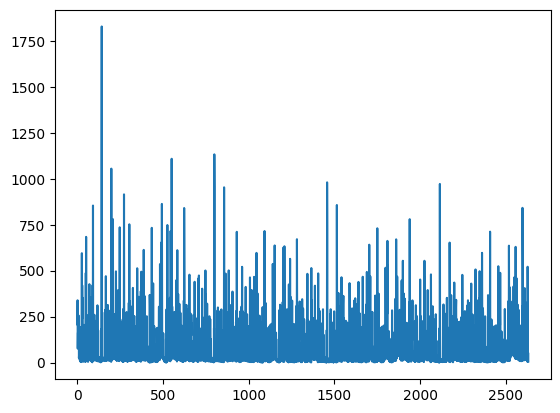

In [63]:
plt.plot([x.numpy() for x in losses])

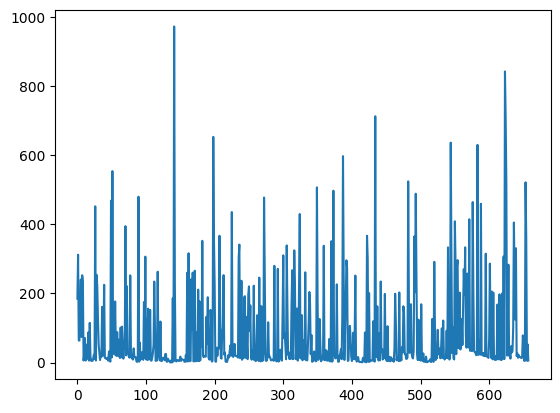

In [64]:
plt.plot([x.numpy() for x in epoch_losses])

## Embedding after Phase I

In [68]:
embedded_data =  [
    model.encoder(x)[0].detach().cpu().numpy()
    for x in input_batches
]

In [78]:
embedded_data = np.vstack(embedded_data)
embedded_data = embedded_data.reshape(embedded_data.shape[0], embedded_data.shape[2])
embedded_data.shape

(33591, 256)

In [79]:
%%time
X_embedded = TSNE(
    n_components=2, learning_rate='auto',
    init='random', perplexity=30
).fit_transform(embedded_data)

CPU times: total: 9min 47s
Wall time: 1min 55s


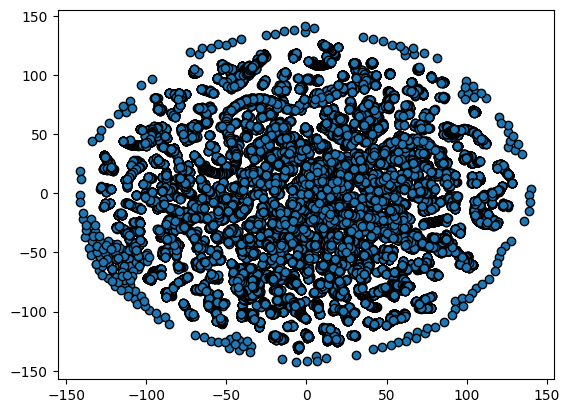

In [81]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], edgecolors="black")

## K Means

In [82]:
from sklearn.cluster import KMeans

In [83]:
kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(X_embedded)

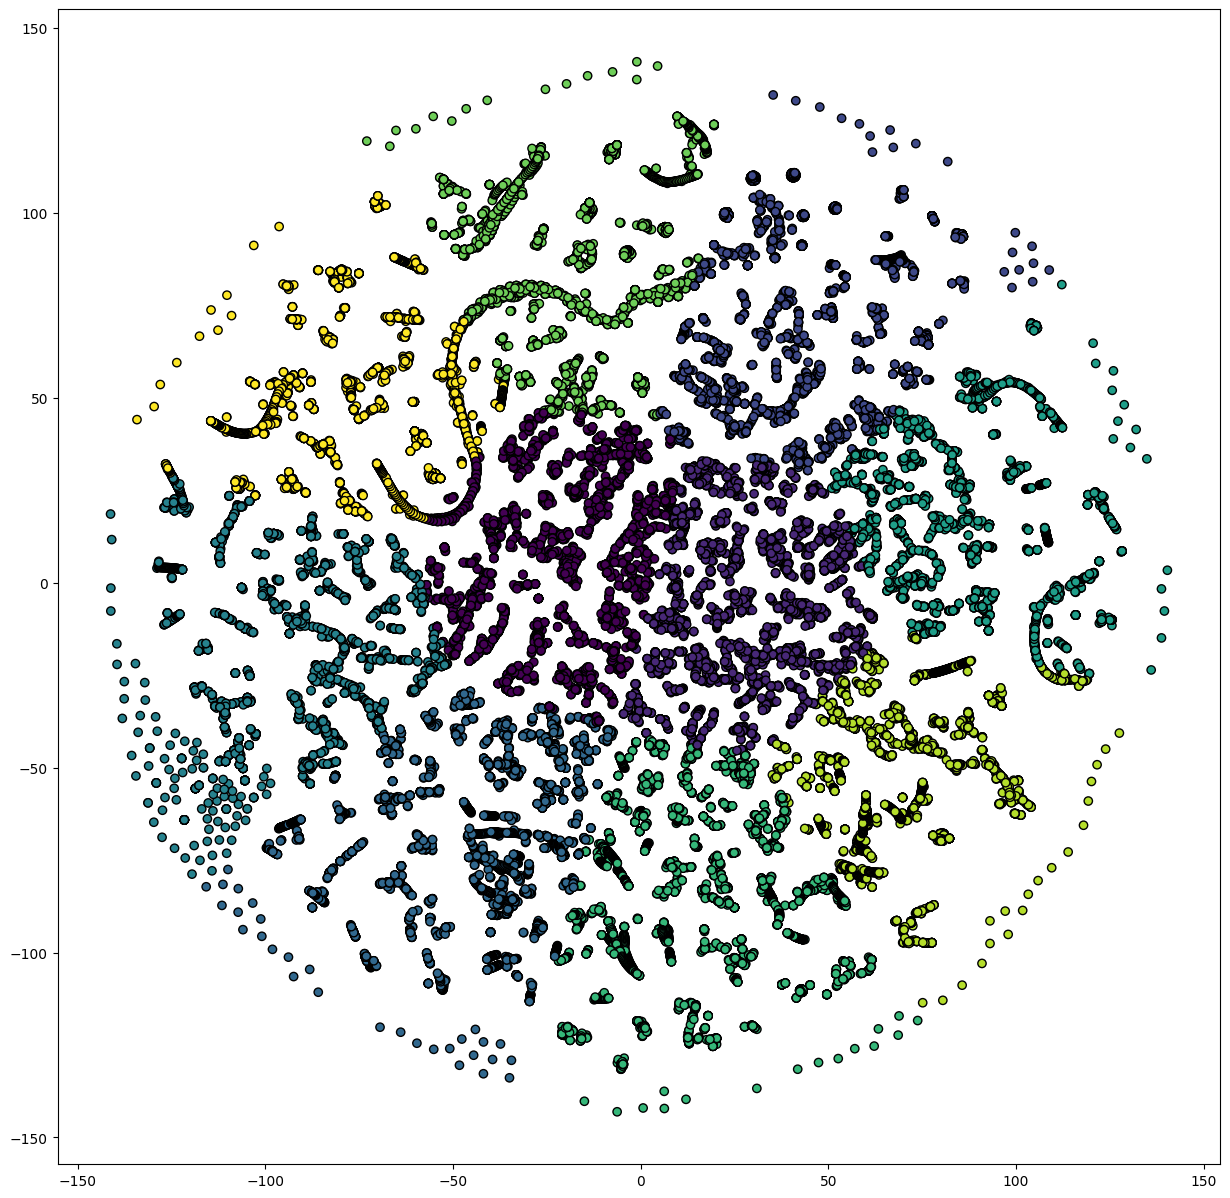

In [102]:
plt.figure(figsize=(15, 15))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], edgecolors="black", c=kmeans.labels_)

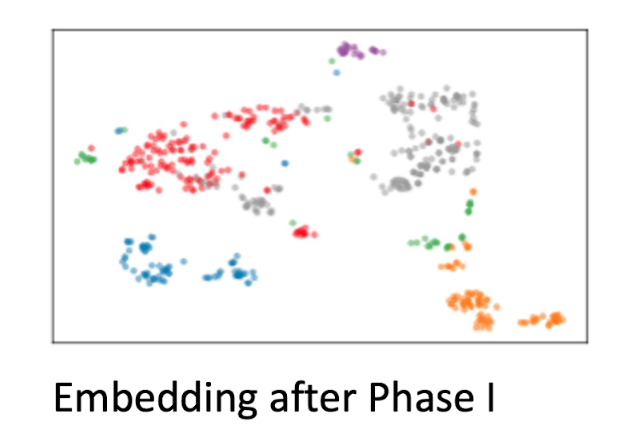


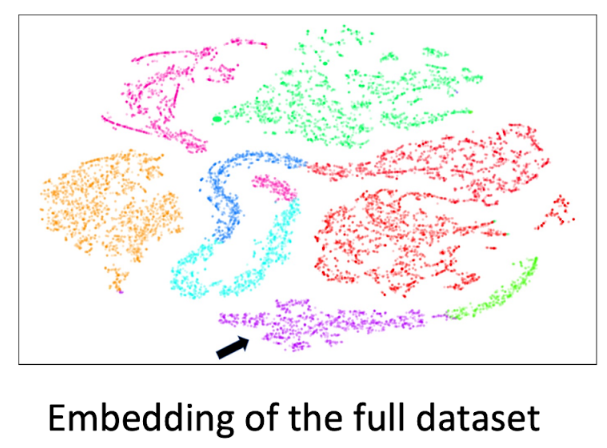

## show trajectories

In [85]:
from src.datareader import DataReader
data_reader = DataReader("VED_dataset/*.csv", files_limit=1)
trajectory_data = data_reader.get_data()

In [88]:
trajectory_data.shape, trajectory_data[0].shape

((658,), (2104, 3))

In [91]:
X_embedded.shape

(33591, 2)

In [92]:
from src.fastspd import FastSPD
fastspd = FastSPD()
compressed_data = [fastspd.compress(row) for _, row in enumerate(trajectory_data)]

In [93]:
all_trajectories = [t for trajectory in compressed_data for t in trajectory ]
len(all_trajectories)

33591

In [96]:
all_trajectories = np.array(all_trajectories)

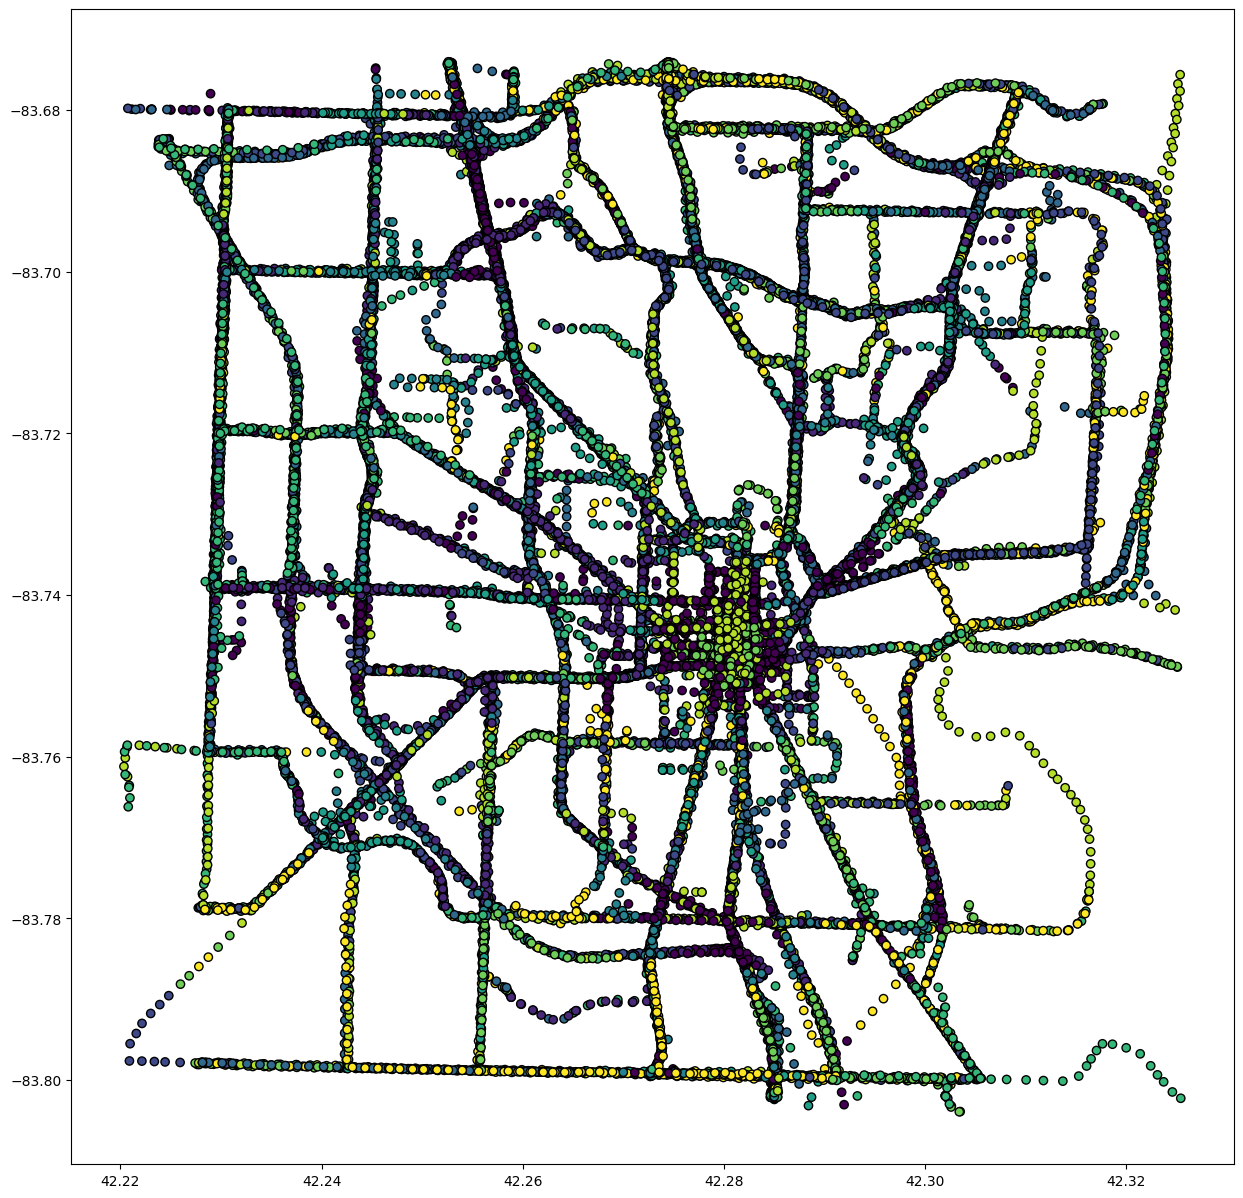

In [101]:
plt.figure(figsize=(15, 15))
plt.scatter(all_trajectories[:, 1], all_trajectories[:, 2], edgecolors="black", c=kmeans.labels_)

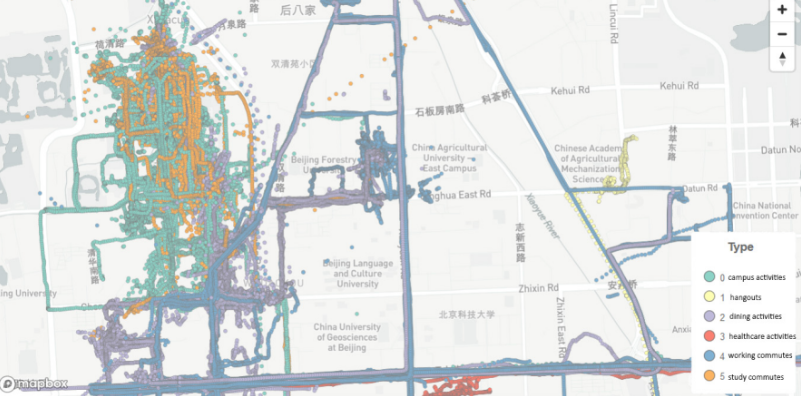